In [101]:
"""
Программа решения двумерного уравнения диффузии.
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg

plt.style.use('ggplot')

def Solve2D(Lx,Nx,Ly,Ny,GammaFun,CSourceFun,VSourceFun,CoefW,ValW,CoefE,ValE,CoefS,ValS,CoefN,ValN):
    
    #Ширина КО
    dx = Lx/Nx
    dy = Ly/Ny
    #грани КО
    XFace = np.linspace(0.0,Lx,Nx+1)
    YFace = np.linspace(0.0,Ly,Ny+1)
    #Площади граней
    dX = np.zeros(Nx)
    dX[:] = XFace[1:Nx+1] - XFace[0:Nx]
    dY = np.zeros(Ny)
    dY[:] = YFace[1:Ny+1] - YFace[0:Ny]
    
    #Создаем массив XP и YP с центрами КО
    XP = np.zeros(Nx)  
    XP = (XFace[0:Nx] + XFace[1:Nx+1])/2.0
    YP = np.zeros(Ny)  
    YP = (YFace[0:Ny] + YFace[1:Ny+1])/2.0
    
    #объемы КО
    VolumeP = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(Nx):
        for iy in range(Ny):
            VolumeP[ix,iy] = dX[ix]*dY[iy]

    #Массив с обобщенным коэффициентом диффузии в центрах КО
    Gamma = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(Nx):
        for iy in range(Ny):
            Gamma[ix,iy] = GammaFun(XP[ix],YP[iy])
    
    CSource = np.zeros(shape = (Nx,Ny),dtype=float)
    VSource = np.zeros(shape = (Nx,Ny),dtype=float)
    
    for ix in range(Nx):
        for iy in range(Ny):
            CSource[ix,iy] = CSourceFun(XP[ix],YP[iy])
            VSource[ix,iy] = VSourceFun(XP[ix],YP[iy])
    
    A = np.zeros((Nx*Ny, Nx*Ny), dtype=float)
    b = np.zeros(Nx*Ny, dtype = float)
    
    #перевод индексов в номер КО
    def k(i,j):
        return i + j*Nx
    #заполнение матрицы
    for ix in range(0,Nx):
        for iy in range(0,Ny):
            kp = k(ix,iy)
            b[kp] = b[kp] + CSource[ix,iy]*VSource[ix,iy]*VolumeP[ix,iy]
            A[kp,kp] = A[kp,kp] + CSource[ix,iy]*VolumeP[ix,iy]
            
            if ix == Nx-1:
                #учитываем влияние правой границы
                anb = 2.0*Gamma[ix,iy]*CoefE/(CoefE*dX[ix] + 2.0*Gamma[ix,iy])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValE
                
            else:
                #учитываем влияние правого КО
                ke = k(ix + 1, iy)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix+1,iy]/(Gamma[ix,iy]*dX[ix+1] + Gamma[ix+1,iy]*dX[ix])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,ke] = -anb
                A[ke,ke] = A[ke,ke] + anb
                A[ke,kp] = -anb 
            if ix == 0:
                #учитываем влияние левой границы
                anb = 2.0*Gamma[ix,iy]*CoefW/(CoefW*dX[ix] + 2.0*Gamma[ix,iy])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValW

             #Задаем периодические ГУ
            if iy == Ny-1:
                kn = k(ix, 0)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix,0]/(Gamma[ix,iy]*dY[0] + Gamma[ix,0]*dY[iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,kn] = -anb
                A[kn,kn] = A[kn,kn] + anb
                A[kn,kp] = -anb           
                
         
            else:
                #учитываем влияние верхнего КО
                kn = k(ix, iy+1)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix,iy+1]/(Gamma[ix,iy]*dY[iy+1] + Gamma[ix,iy+1]*dY[iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,kn] = -anb
                A[kn,kn] = A[kn,kn] + anb
                A[kn,kp] = -anb 
            if iy == 0:
                #учитываем влияние нижней границы
                anb = 2.0*Gamma[ix,iy]*CoefS/(CoefS*dY[iy] + 2.0*Gamma[ix,iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValS          
            
                
    Phi,info = linalg.gmres(A, b)
    Phi2D = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(0,Nx):
        for iy in range(0,Ny):
            kp = k(ix,iy)
            Phi2D[ix,iy] = Phi[kp]
   
    qsr = 0
    for k in range(Ny):
        #qsr = qsr + (ValW-Phi2D[0,k])/(1/CoefW+dx/(2*Gamma[0,k])) #левая граница
        qsr += CoefW * (ValW - Phi2D[0,iy])

        #Ja = Ja + (TRight-Phi2D[Nx-1,j])/(1/CoefE+dx/(2*Gamma[0,j]))
    qsr = qsr/Ny
    
    Lambdaeff = abs(-qsr*Lx/((ValW-ValE)-(2*qsr/CoefW)))
    
    return XP, XFace, YP, YFace, Phi2D, Gamma, qsr, Lambdaeff
    
  

In [102]:
#Параметры тестовой задачи
w = 4
delta1 = 1.0
delta2 = 0.4
Lx = (w+1)*delta1+4*delta2 #длина расчетной области
Nx = 32 #количество контрольных объемов
Ly = 3*delta2 #высота расчетной области
Ny = 16 #количество контрольных объемов
Lambdabebra = 1.0 #коэффициент теплопроводности
qv = 0.0 #внутреннее тепловыделение
alphaLeft = 1.0
TLeft = 1.0
alphaRight = 1.0
TRight = 0.0
alphaUp = 0.0
TUp = 0.0
alphaDown = 0.0
TDown = 0.0



    
def LambdaFun(x,y):
    retVal = Lambdabebra
    if x>=delta1 and x<=delta1+delta2 and y>=0 and y<=delta2/2:
        retVal=60*Lambdabebra
    if x>=2*delta1+delta2 and x<=2*delta1+2*delta2 and y>=delta2/2 and y<=delta2/2 + delta2:
        retVal=60*Lambdabebra
    if x>=3*delta1+2*delta2 and x<=3*delta1+3*delta2 and y>=delta2/2 + delta2 and y<=delta2/2 + 2*delta2:##
        retVal=60*Lambdabebra
    if x>=4*delta1+3*delta2 and x<=4*delta1+4*delta2 and y>=0 and y<=delta2/2:
        retVal=60*Lambdabebra
    if x>=delta1 and x<=delta1+delta2 and y>=delta2/2 + 2*delta2 and y<=delta2/2 + 2*delta2 + delta2/2:
        retVal=60*Lambdabebra
    if x>=4*delta1 + 3*delta2 and x<=4*delta1+4*delta2 and y>=delta2/2 + 2*delta2 and y<=delta2/2 + 2*delta2 + delta2/2:
        retVal=60*Lambdabebra    
        
    return retVal
   

def CSourceFun(x,y):
    return 1.0e-20

def VSourceFun(x,y):
    return qv/1.0e-20

теплововй поток черз левую стенку 0.14411432446893135
эфеективный коэффициент теплопроводности 1.3363203507356558
число Био= 1.0


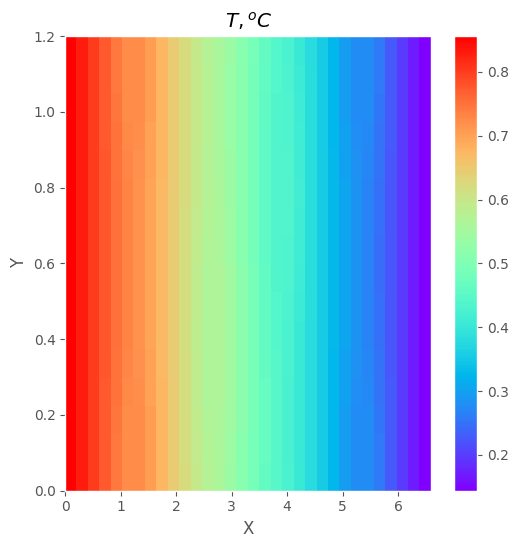

In [ ]:
#Решение
x, xf, y, yf, T, Gamma, qsr, Lambdaeff = Solve2D(Lx,Nx,Ly,Ny,LambdaFun,CSourceFun,VSourceFun,alphaLeft,TLeft,alphaRight,TRight,alphaDown,TDown,alphaUp,TUp)
print("средняя плотность теплового потока", qsr)
print("эфеективный коэффициент теплопроводности", Lambdaeff)
print("число Био=",alphaRight*delta1/Lambdabebra)
#Строим графики
fig = plt.figure('fig1',figsize=(150.0/25.4,150.0/25.4))
plt.pcolor(xf, yf, T.T,cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.show()

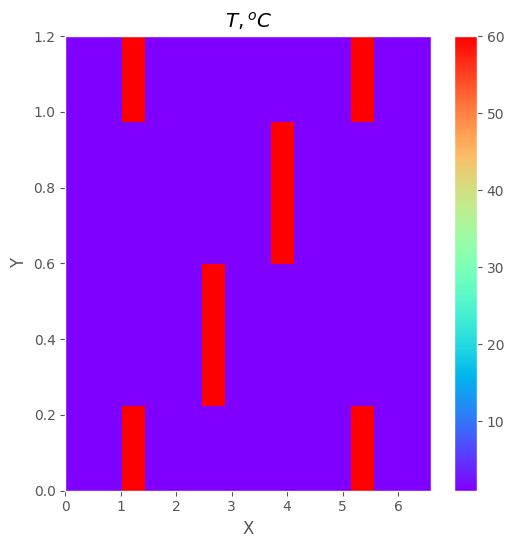

In [104]:

#Строим графики
fig = plt.figure('fig1',figsize=(150.0/25.4,150.0/25.4))
plt.pcolor(xf, yf, Gamma.T,cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.show()

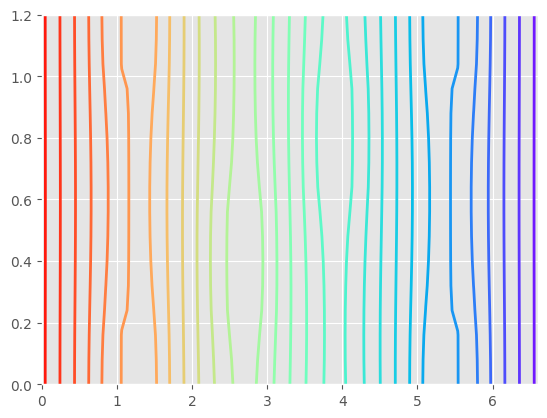

In [105]:
plt.contour(T.T,Nx,cmap='rainbow',extent = (0.0,Lx,0.0,Ly),linewidths = 2)